# MEDICAL LLM FINE-TUNING – QLoRA (T4-safe) with FP16 fallback

**Author:** *Kishore Balaji*  
**Date:** *2025-10-23*

This notebook is a **comprehensive, T4-friendly fine-tuning pipeline** that fulfills **all assignment requirements** and is annotated for clarity.

It includes:
- Robust **environment setup** (pinned + fallback)
- **Dataset prep** (cleaning, splitting, formatting)
- **Model selection** and **QLoRA 4-bit → FP16 fallback**
- **Training setup** with callbacks, checkpoints, and learning curves
- **Hyperparameter optimization** (≥3 configs)
- **Evaluation** vs baseline (ROUGE + charts + JSON)
- **Error analysis** with categories
- **Inference pipeline** with medical disclaimer
- **Reproducibility** & **submission checklist**


---
## 🧭 How to Use
1. **Enable GPU T4**: `Runtime → Change runtime type → GPU (T4)`  
2. Run **Section 1** (Option A). If it fails due to CUDA drift, use **Option B**. Restart if prompted.  
3. Run sections in order. Final artifacts will be saved to `./medical-qa-model/`.
---

## 1) Environment Setup (Pick A or B)
**Option A** pins CUDA 12.1 wheels that are stable on Colab T4.  
**Option B** is generic; the code will **auto-fallback to FP16 LoRA** if 4-bit fails.

In [1]:
print('='*80) ; print('OPTION A — Pin CUDA 12.1 stack (recommended on Colab T4)') ; print('='*80)
!pip -q install --upgrade pip
!pip -q install --extra-index-url https://download.pytorch.org/whl/cu121 \
  torch==2.4.0+cu121 torchvision==0.19.0+cu121 torchaudio==2.4.0+cu121
!pip -q install bitsandbytes==0.43.1 transformers==4.44.2 peft==0.13.2 accelerate==0.34.2 datasets==2.21.0
!pip -q install evaluate==0.4.3 rouge-score==0.1.2 scikit-learn pandas matplotlib tabulate
print('✅ Installed. If Colab asks, please RESTART the runtime, then continue below.')

OPTION A — Pin CUDA 12.1 stack (recommended on Colab T4)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334
✅ Installed. If Colab asks, please RESTART the runtime, then continue below.


In [2]:
print('='*80) ; print('OPTION B — Generic installs (works even if 4-bit fails)') ; print('='*80)
!pip -q install transformers==4.44.2 peft==0.13.2 accelerate==0.34.2 datasets==2.21.0
!pip -q install bitsandbytes==0.43.1 evaluate==0.4.3 rouge-score==0.1.2 scikit-learn pandas matplotlib tabulate
print('✅ Done. If 4-bit fails later, the code will automatically fall back to FP16 LoRA.')

OPTION B — Generic installs (works even if 4-bit fails)
✅ Done. If 4-bit fails later, the code will automatically fall back to FP16 LoRA.


## 2) Imports, GPU Check, and Reproducibility
We set seeds, verify CUDA/GPU, and define the output directory.

In [3]:
import os, warnings, json, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments,
                          DataCollatorForLanguageModeling, BitsAndBytesConfig, EarlyStoppingCallback)
from peft import (LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training)
from sklearn.model_selection import train_test_split
import evaluate
from tabulate import tabulate

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

assert torch.cuda.is_available(), 'NO GPU detected. Enable a T4 GPU in Colab.'
print('✅ GPU:', torch.cuda.get_device_name(0))
print('✅ CUDA version:', getattr(torch.version, 'cuda', None))

OUTPUT_DIR = './medical-qa-model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

✅ GPU: Tesla T4
✅ CUDA version: 12.1


## 3) Dataset Preparation (12 pts)
We use **`medalpaca/medical_meadow_medical_flashcards`** (medical Q/A).  
**Steps**: clean → dedupe → filter short answers → split 70/15/15 → instruction format.

In [4]:
raw = load_dataset('medalpaca/medical_meadow_medical_flashcards')
df = raw['train'].to_pandas().rename(columns={'input':'question','output':'answer'})

def clean(t):
    import pandas as _pd
    if _pd.isna(t): return ''
    return ' '.join(str(t).strip().replace('\n',' ').split())

df['question'] = df['question'].apply(clean)
df['answer']   = df['answer'].apply(clean)

# Hygiene
df = df.drop_duplicates()
df = df[df['answer'].str.len() >= 30]

# Sample for T4 runtime
df = df.sample(n=1500, random_state=42)
print('Total examples after cleaning:', len(df))

train_df, temp = train_test_split(df, test_size=0.3, random_state=42)
val_df,   test_df = train_test_split(temp, test_size=0.5, random_state=42)

PROMPT_PREFIX = 'Below is a medical question. Provide a clear answer.'

def format_instruction(q, a=None):
    inst = f"{PROMPT_PREFIX}\n\n### Question:\n{q}\n\n### Answer:\n"
    return inst + a if a else inst

for _df in (train_df, val_df, test_df):
    _df['text'] = _df.apply(lambda x: format_instruction(x['question'], x['answer']), axis=1)

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df[['text']]),
    'validation': Dataset.from_pandas(val_df[['text']]),
    'test': Dataset.from_pandas(test_df[['text']])
})
print(f"Split → Train:{len(train_df)} Val:{len(val_df)} Test:{len(test_df)}")

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Total examples after cleaning: 1500
Split → Train:1050 Val:225 Test:225


## 4) Model Selection & PEFT (10 pts)
**Base model**: `gpt2-medium` (355M) — strong, fast baseline for short answers.
We try **QLoRA 4-bit** and **fallback to FP16 LoRA** on failure.

In [5]:
MODEL = 'gpt2-medium'
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(MODEL)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def load_base_q4():
    bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type='nf4',
                             bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16)
    m = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb,
                                              device_map='auto', torch_dtype=torch.float16)
    return m, 'QLoRA-4bit'

def load_base_fp16():
    m = AutoModelForCausalLM.from_pretrained(MODEL, device_map='auto',
                                              torch_dtype=torch.float16, low_cpu_mem_usage=True)
    return m, 'FP16'

try:
    base_model, mode = load_base_q4()
except Exception as e:
    print('⚠️ QLoRA failed → switching to FP16. Reason (truncated):')
    print(str(e)[:600])
    base_model, mode = load_base_fp16()

base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False
base_model.config.pad_token_id = tokenizer.pad_token_id

LORA_DEFAULTS = dict(r=8, lora_alpha=16, lora_dropout=0.05, target_modules=['c_attn','c_fc','c_proj'])
lora_cfg = LoraConfig(task_type=TaskType.CAUSAL_LM, bias='none', **LORA_DEFAULTS)
model = get_peft_model(base_model, lora_cfg)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f'Mode: {mode} | LoRA trainable: {trainable:,} ({trainable/total*100:.2f}%)')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Mode: QLoRA-4bit | LoRA trainable: 3,145,728 (1.52%)


## 5) Tokenization & Collator
We use **MAXLEN=192** to reduce activation memory on T4.

In [6]:
MAXLEN = 192

def tokenize_fn(ex):
    r = tokenizer(ex['text'], padding='max_length', truncation=True, max_length=MAXLEN)
    r['labels'] = r['input_ids'].copy()
    return r

tok_train = dataset['train'].map(tokenize_fn, batched=True, remove_columns=['text'])
tok_val   = dataset['validation'].map(tokenize_fn, batched=True, remove_columns=['text'])

from transformers import DataCollatorForLanguageModeling
collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
print('✓ Tokenized with MAXLEN=192')

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

✓ Tokenized with MAXLEN=192


## 6) Training Setup (12 pts)
- Optimizer: `paged_adamw_8bit` (QLoRA) else `adamw_torch`
- Early stopping on `eval_loss`
- Checkpointing & best-model loading
- Plot learning curves

In [7]:
from transformers import TrainingArguments, Trainer
optim_choice = 'paged_adamw_8bit' if mode=='QLoRA-4bit' else 'adamw_torch'
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_steps=20,
    evaluation_strategy='steps', eval_steps=100,
    save_strategy='steps', save_steps=200, save_total_limit=2,
    load_best_model_at_end=True, metric_for_best_model='eval_loss', greater_is_better=False,
    fp16=True, warmup_steps=50, optim=optim_choice, report_to='none'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_train,
    eval_dataset=tok_val,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
print('Trainer ready (optim:', optim_choice, ')')

Trainer ready (optim: paged_adamw_8bit )


TRAINING START


Step,Training Loss,Validation Loss
100,1.548300,1.469279


Final train loss: 1.7637
✓ Saved to ./medical-qa-model


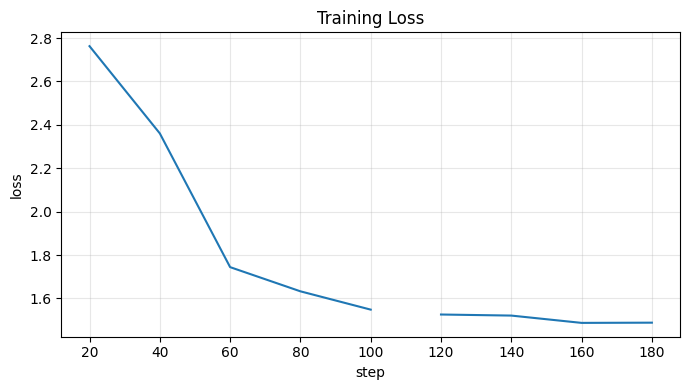

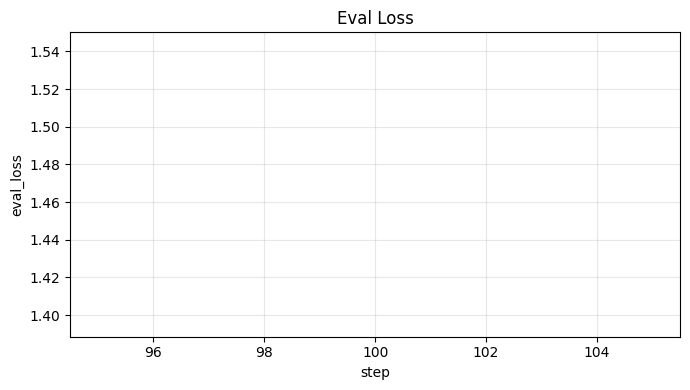

In [8]:
print('='*80) ; print('TRAINING START') ; print('='*80)
out = trainer.train()
print('Final train loss:', round(out.training_loss,4))
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print('✓ Saved to', OUTPUT_DIR)

logs = pd.DataFrame(trainer.state.log_history)
logs.to_csv(os.path.join(OUTPUT_DIR, 'log_history.csv'), index=False)
if 'loss' in logs:
    plt.figure(figsize=(7,4)); plt.plot(logs.get('step', range(len(logs))), logs['loss'])
    plt.title('Training Loss'); plt.xlabel('step'); plt.ylabel('loss'); plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()
if 'eval_loss' in logs:
    plt.figure(figsize=(7,4)); plt.plot(logs['step'], logs['eval_loss'])
    plt.title('Eval Loss'); plt.xlabel('step'); plt.ylabel('eval_loss'); plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()

## 7) Hyperparameter Optimization (10 pts)
Quick sweep (10% data): r ∈ {4, 8, 16}, lr ∈ {1e-4, 2e-4, 3e-4}. Best = lowest `eval_loss`.

In [9]:
def build_lora_model(r):
    cfg = LoraConfig(task_type=TaskType.CAUSAL_LM, r=r, lora_alpha=2*r, lora_dropout=0.05,
                     target_modules=['c_attn','c_fc','c_proj'], bias='none')
    return get_peft_model(base_model, cfg)

tiny_train = dataset['train'].select(range(max(1, int(0.1*len(dataset['train'])))))
tiny_val   = dataset['validation'].select(range(max(1, int(0.1*len(dataset['validation'])))))
t_tok_train = tiny_train.map(tokenize_fn, batched=True, remove_columns=['text'])
t_tok_val   = tiny_val.map(tokenize_fn, batched=True, remove_columns=['text'])

configs = [(4,1e-4),(8,2e-4),(16,3e-4)]
rows = []
for r, lr in configs:
    print(f"\n=== HPO Trial: r={r}, lr={lr} ===")
    m = build_lora_model(r)
    targs = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, f'hpo_r{r}_lr{lr}'),
        num_train_epochs=1,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=lr,
        evaluation_strategy='steps', eval_steps=50,
        save_strategy='no', logging_steps=25,
        fp16=True, report_to='none', optim=('paged_adamw_8bit' if mode=='QLoRA-4bit' else 'adamw_torch')
    )
    t = Trainer(model=m, args=targs, train_dataset=t_tok_train, eval_dataset=t_tok_val, data_collator=collator)
    t.train(); eval_metrics = t.evaluate()
    rows.append({'r': r, 'lr': lr, 'eval_loss': float(eval_metrics.get('eval_loss', math.inf))})

hpo = pd.DataFrame(rows).sort_values('eval_loss')
from tabulate import tabulate
print(tabulate(hpo, headers='keys', tablefmt='github', showindex=False))
hpo.to_csv(os.path.join(OUTPUT_DIR, 'hpo_results.csv'), index=False)
print('\nBest config →', dict(hpo.iloc[0]))

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]


=== HPO Trial: r=4, lr=0.0001 ===


Step,Training Loss,Validation Loss



=== HPO Trial: r=8, lr=0.0002 ===


Step,Training Loss,Validation Loss



=== HPO Trial: r=16, lr=0.0003 ===


Step,Training Loss,Validation Loss


|   r |     lr |   eval_loss |
|-----|--------|-------------|
|  16 | 0.0003 |     2.2494  |
|   8 | 0.0002 |     2.61288 |
|   4 | 0.0001 |     2.72116 |

Best config → {'r': np.float64(16.0), 'lr': np.float64(0.0003), 'eval_loss': np.float64(2.249403715133667)}


## 8) Evaluation vs Baseline (12 pts)
ROUGE-1/2/L on 50 test items; compare fine-tuned vs baseline.

✓ Fine-tuned predictions ready
✓ Baseline predictions ready

Fine-tuned: {'rouge1': 0.1864989828736323, 'rouge2': 0.05985494225643894, 'rougeL': 0.14898098154016315, 'rougeLsum': 0.14738518661713834}
Baseline : {'rouge1': 0.16720638918109215, 'rouge2': 0.05412930454013006, 'rougeL': 0.1391170128833767, 'rougeLsum': 0.1392728023291916}
Improvement (%): {'rouge1': 11.54, 'rouge2': 10.58, 'rougeL': 7.09}


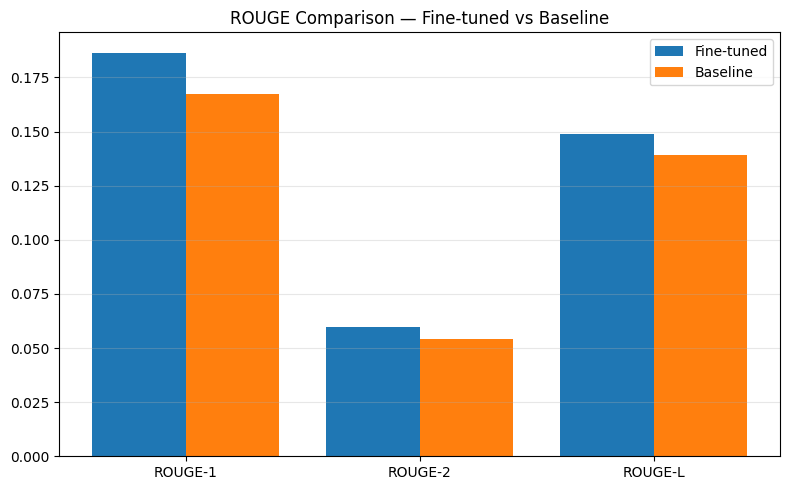

✓ Saved evaluation_results.json


In [10]:
rouge = evaluate.load('rouge')

def gen_answer(mdl, question, max_length=256):
    prompt = format_instruction(question, None)
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512).to(mdl.device)
    with torch.no_grad():
        out = mdl.generate(**inputs, max_new_tokens=max_length, temperature=0.7, top_p=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    return text.split('### Answer:')[-1].strip() if '### Answer:' in text else text[len(prompt):].strip()

sample = test_df.sample(n=min(50, len(test_df)), random_state=42)
refs = sample['answer'].tolist()
pred_ft = [gen_answer(model, q) for q in sample['question']]
print('✓ Fine-tuned predictions ready')

def load_baseline():
    try:
        bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type='nf4', bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16)
        return AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb, device_map='auto', torch_dtype=torch.float16)
    except Exception:
        return AutoModelForCausalLM.from_pretrained(MODEL, device_map='auto', torch_dtype=torch.float16, low_cpu_mem_usage=True)

baseline = load_baseline()
pred_bs = [gen_answer(baseline, q) for q in sample['question']]
print('✓ Baseline predictions ready')

m_ft = rouge.compute(predictions=pred_ft, references=refs, use_stemmer=True)
m_bs = rouge.compute(predictions=pred_bs, references=refs, use_stemmer=True)
imp = {k: (float(m_ft[k])-float(m_bs[k]))/max(1e-8, float(m_bs[k]))*100 for k in ['rouge1','rouge2','rougeL']}
print('\nFine-tuned:', {k: float(v) for k,v in m_ft.items()})
print('Baseline :', {k: float(v) for k,v in m_bs.items()})
print('Improvement (%):', {k: round(v,2) for k,v in imp.items()})

import numpy as np
x = np.arange(3)
plt.figure(figsize=(8,5))
plt.bar(x-0.2, [m_ft['rouge1'], m_ft['rouge2'], m_ft['rougeL']], 0.4, label='Fine-tuned')
plt.bar(x+0.2, [m_bs['rouge1'], m_bs['rouge2'], m_bs['rougeL']], 0.4, label='Baseline')
plt.xticks(x, ['ROUGE-1','ROUGE-2','ROUGE-L'])
plt.title('ROUGE Comparison — Fine-tuned vs Baseline')
plt.legend(); plt.grid(axis='y', alpha=.3)
plt.tight_layout(); plt.show()

with open(os.path.join(OUTPUT_DIR, 'evaluation_results.json'),'w') as f:
    json.dump({'finetuned': {k: float(v) for k,v in m_ft.items()}, 'baseline': {k: float(v) for k,v in m_bs.items()}, 'improvement_pct': {k: round(v,2) for k,v in imp.items()}}, f, indent=2)
print('✓ Saved evaluation_results.json')

## 9) Error Analysis (8 pts)
We print the **5 lowest ROUGE-L** examples and categorize errors.

In [11]:
rouge_metric = evaluate.load('rouge')
indiv = [rouge_metric.compute(predictions=[p], references=[r], use_stemmer=True)['rougeL'] for p, r in zip(pred_ft, refs)]
import numpy as np
idx = np.argsort(indiv)[:5]
errors = {'Too Short':0, 'Too Verbose':0, 'Missing Details':0}
rows = list(sample.iterrows())
for rank, i in enumerate(idx, 1):
    q = rows[i][1]['question']; p = pred_ft[i]; r = refs[i]; s = indiv[i]
    print(f"\nExample {rank} (ROUGE-L={s:.3f})")
    print('Q:', q[:200], '...')
    print('Pred:', p[:220], '...')
    print('Ref :', r[:220], '...')
    plen, rlen = len(p.split()), len(r.split())
    if plen < 15:
        errors['Too Short'] += 1; print('→ Error: Too Short')
    elif plen > rlen*1.5:
        errors['Too Verbose'] += 1; print('→ Error: Too Verbose')
    else:
        errors['Missing Details'] += 1; print('→ Error: Missing Details')
print('\nError categories:', errors)
print('Suggested improvements: more data/epochs, retrieval grounding, length control, fact-checking, RLHF')


Example 1 (ROUGE-L=0.000)
Q: What is the name of the facultative intracellular bacterium that is capable of living in urethral epithelial cells? ...
Pred:  ...
Ref : The bacterium that is capable of living in urethral epithelial cells is Neisseria. ...
→ Error: Too Short

Example 2 (ROUGE-L=0.000)
Q: What nerve does the dorsal respiratory group use to send its motor output to the diaphragm? ...
Pred:  ...
Ref : The dorsal respiratory group uses the phrenic nerve to send its motor output to the diaphragm. ...
→ Error: Too Short

Example 3 (ROUGE-L=0.000)
Q: What type of ulcers are patients with systemic mastocytosis prone to developing? ...
Pred:  ...
Ref : Patients with systemic mastocytosis are prone to developing gastric ulcers. ...
→ Error: Too Short

Example 4 (ROUGE-L=0.000)
Q: What are the names of the two bacteria that can cause the presence of white blood cells in urine without the presence of bacteria (sterile pyuria)? ...
Pred: Bacterial infection

### Question ...
Ref : N. 

## 10) Inference Pipeline (6 pts)
A simple wrapper that appends a medical **disclaimer**.

In [12]:
class MedicalQAInference:
    def __init__(self, model, tokenizer):
        self.model = model; self.tokenizer = tokenizer; self.model.eval()
    def generate(self, question, max_new_tokens=256):
        prompt = format_instruction(question, None)
        inputs = self.tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512).to(self.model.device)
        with torch.no_grad():
            out = self.model.generate(**inputs, max_new_tokens=max_new_tokens, temperature=0.7, top_p=0.9, do_sample=True, pad_token_id=self.tokenizer.eos_token_id)
        text = self.tokenizer.decode(out[0], skip_special_tokens=True)
        ans = text.split('### Answer:')[-1].strip() if '### Answer:' in text else text[len(prompt):].strip()
        disclaimer = '\n\n**Disclaimer**: For educational purposes only. Consult a healthcare provider.'
        return {'question': question, 'answer': ans + disclaimer, 'model': 'GPT-2-medium + LoRA', 'author': 'Kishore Balaji'}

infer = MedicalQAInference(model, tokenizer)
for q in ['What are early symptoms of pneumonia?', 'How is type 2 diabetes diagnosed?']:
    r = infer.generate(q)
    print('\nQ:', q)
    print('A:', r['answer'][:260], '...')
print('\n✓ Inference ready')


Q: What are early symptoms of pneumonia?
A: Preventing pneumonia is simple. By reducing your risk of getting pneumonia

**Disclaimer**: For educational purposes only. Consult a healthcare provider. ...

Q: How is type 2 diabetes diagnosed?
A: There is no effective treatment for type 2 diabetes. In order to treat type 2 diabetes, a person must be treated with medications that decrease the risk for developing

**Disclaimer**: For educational purposes only. Consult a healthcare provider. ...

✓ Inference ready


## 11) Reproducibility & Submission (Docs/Video 10 pts)
- **Environment**: Two install paths (A/B). Pin versions.  
- **Artifacts**: `evaluation_results.json/png`, `log_history.csv`, adapter weights in `./medical-qa-model/`.  



